# Mommy Fortuna's Midnight Carnival of Python Oddities

## Exhibit 1: The Wonders and Pitfalls of Promotion

Numerical variables in the Python language have associated data types,
but you may not have noticed because Python automatically
converts between them.  However, the behavior of this conversion
can depend on the data type, so be careful.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cases = [
    '1.0 / 2',
    '1 / 2',
    'np.array([1]) / np.array([2])',
    '1.0 // 2',
    '1 // 2',
    'np.array([1]) // np.array([2])',
]

for cnt, eqn in enumerate(cases):
    ans = eval(eqn)
    if 'np' in eqn:
        dtype = ans.dtype
    else:
        dtype = type(ans)
    print(f'Case {cnt}: {eqn} = {ans} of type {dtype}')

Case 0: 1.0 / 2 = 0.5 of type <class 'float'>
Case 1: 1 / 2 = 0.5 of type <class 'float'>
Case 2: np.array([1]) / np.array([2]) = [0.5] of type float64
Case 3: 1.0 // 2 = 0.0 of type <class 'float'>
Case 4: 1 // 2 = 0 of type <class 'int'>
Case 5: np.array([1]) // np.array([2]) = [0] of type int64


In [3]:
cases = [
    '[0] * 2',  # list times an integer
    '[0] * 2.0', # list times float causes exception
]

for cnt, eqn in enumerate(cases):
    try:
        ans = eval(eqn)
    except(TypeError):
        ans = 'TypeError'
    print(f'Case {cnt}: {eqn} = {ans}')

Case 0: [0] * 2 = [0, 0]
Case 1: [0] * 2.0 = TypeError


## Exhibit 2: Precision, and the Lack Thereof

Numpy has a stricter notation of data types.  The data type of
an array is static, but numpy will promote data types when
you perform an operation that creates a new array.   Numpy
data types often behave differently than their Python cousins.

In [4]:
x = np.array([0, 1, 2])
print(x.dtype)
print((x * 1.).dtype) # a new array is created with promoted type
x *= 1. # error: the new promoted array cannot be assigned to the original

int64
float64


UFuncTypeError: Cannot cast ufunc 'multiply' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

Depending on the data type, results can only be represented with a finite precision.

In [5]:
dtypes = [np.int16, np.int32, np.int64, np.float32, np.float64]

for dtype in dtypes:
    data = np.array([1, 1, 3], dtype=dtype)
    print(dtype, np.average(data), np.average(data).dtype, np.average(data).astype(dtype) * 3)

<class 'numpy.int16'> 1.6666666666666667 float64 3
<class 'numpy.int32'> 1.6666666666666667 float64 3
<class 'numpy.int64'> 1.6666666666666667 float64 3
<class 'numpy.float32'> 1.6666666 float32 5.0
<class 'numpy.float64'> 1.6666666666666667 float64 5.0


Beware the finite precision of floats!

In [6]:
for dtype in dtypes:
    try:
        print(dtype, np.array([2**24+1], dtype=dtype))
    except(OverflowError):
        print(f'{dtype} had OverflowError')

<class 'numpy.int16'> had OverflowError
<class 'numpy.int32'> [16777217]
<class 'numpy.int64'> [16777217]
<class 'numpy.float32'> [16777216.]
<class 'numpy.float64'> [16777217.]


In [7]:
print(np.sin(np.pi), np.cos(np.pi/2))  # note how cos isn't zero

1.2246467991473532e-16 6.123233995736766e-17


For large values, integers may wrap and floats may behave unexpectedly. Numpy arrays don't raise exceptions the way Python values do.

In [8]:
for dtype in dtypes:
    big_number = np.array([2], dtype=dtype)**24
    smaller_big_number = np.array([2], dtype=dtype)**24
    print(dtype, big_number, (big_number + 1) - smaller_big_number)

<class 'numpy.int16'> [0] [1]
<class 'numpy.int32'> [16777216] [1]
<class 'numpy.int64'> [16777216] [1]
<class 'numpy.float32'> [16777216.] [0.]
<class 'numpy.float64'> [16777216.] [1.]


In [9]:
print(np.log(np.exp(1000)))
print(np.exp(np.log(1000)))

inf
999.9999999999998


/tmp/ipykernel_20241/198834523.py:1: RuntimeWarning: overflow encountered in exp
  print(np.log(np.exp(1000)))


In [10]:
print(np.array([1.])/0)
print(1./0)

[inf]


/tmp/ipykernel_20241/937139305.py:1: RuntimeWarning: divide by zero encountered in divide
  print(np.array([1.])/0)


ZeroDivisionError: float division by zero

## Exhibit 3: Numerical Instability

Numerical precision can have unexpected effects on numerical code.
For example, polynomial fitting grows unstable for large-degree polynimals.
Numerical stability is tricky to track down and can be platform dependent.

/tmp/ipykernel_20241/3480443910.py:5: RankWarning: Polyfit may be poorly conditioned
  p20 = np.polyfit(x,y,deg=20)


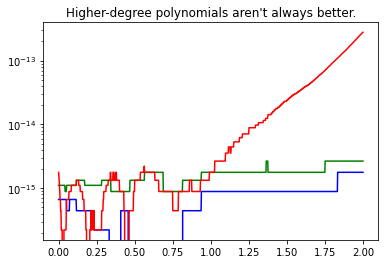

In [11]:
x = np.linspace(0,2,1024)
y = 3*x + 1 # fitting to linear data should ideally be perfect
p1 = np.polyfit(x,y,deg=1)
p2 = np.polyfit(x,y,deg=2)
p20 = np.polyfit(x,y,deg=20)

plt.title("Higher-degree polynomials aren't always better.")
plt.semilogy(x, np.abs(np.polyval(p1, x) - y), 'b')
plt.semilogy(x, np.abs(np.polyval(p2, x) - y), 'g')
plt.semilogy(x, np.abs(np.polyval(p20, x) - y), 'r')
plt.show()

## Exhibit 4: When is a Duck When it Isn't

Sometimes, variables are completely independent from each other.  Sometimes
they actually refer to the same underlying object.  Python calls
this behavior 'mutability'.  Some data types are mutable (variables point
to the same object), while others are immutable.

In [12]:
a = 1
b = a
a = 2
print(a, b)

a = [1]
b = a
a[0] = 2
print(a, b)

2 1
[2] [2]


In [13]:
def double_it(x):
    x *= 2
    return x

a = 1
print(double_it(a), a)
a = [1]
print(double_it(a), a)
a = (1,)
print(double_it(a), a)

2 1
[1, 1] [1, 1]
(1, 1) (1,)


In [14]:
x = [0] * 5
x[1] = 3
print(x)

x = [[0]] * 5
x[1][0] = 3
print(x)

[0, 3, 0, 0, 0]
[[3], [3], [3], [3], [3]]


## Exhibit 5: Disorder

Some attributes, notably the iteration order of sets, are
arbitrary and change between platforms, or even between serialization
and de-serialization (e.g. when writing to disk).  Good code should
not rely on aspects of these attributes that are not guaranteed.

In [15]:
import pickle
data1 = set(['cow', 'bug', 'noodle'])
print(data1)
s = pickle.dumps(data1)
data2 = pickle.loads(s)
print(data2)

{'noodle', 'bug', 'cow'}
{'noodle', 'bug', 'cow'}


# Exhibit 6: For loop assignment

For loops will assign to anything that can take assignment. Maybe not surprising, but perhaps not intuitive.

In [16]:
d = {'dog':'woof','cat':'meow','bird':'tweet',
     'mouse':'squeak','cow':'moo', 'frog':'croak',
     'elephant':'toot','duck':'quack','fish':'blub',
     'seal':'ow ow ow','fox':None}

values = "haki haki haki ho"

for d["fox"] in values:
    print(d)

{'dog': 'woof', 'cat': 'meow', 'bird': 'tweet', 'mouse': 'squeak', 'cow': 'moo', 'frog': 'croak', 'elephant': 'toot', 'duck': 'quack', 'fish': 'blub', 'seal': 'ow ow ow', 'fox': 'h'}
{'dog': 'woof', 'cat': 'meow', 'bird': 'tweet', 'mouse': 'squeak', 'cow': 'moo', 'frog': 'croak', 'elephant': 'toot', 'duck': 'quack', 'fish': 'blub', 'seal': 'ow ow ow', 'fox': 'a'}
{'dog': 'woof', 'cat': 'meow', 'bird': 'tweet', 'mouse': 'squeak', 'cow': 'moo', 'frog': 'croak', 'elephant': 'toot', 'duck': 'quack', 'fish': 'blub', 'seal': 'ow ow ow', 'fox': 'k'}
{'dog': 'woof', 'cat': 'meow', 'bird': 'tweet', 'mouse': 'squeak', 'cow': 'moo', 'frog': 'croak', 'elephant': 'toot', 'duck': 'quack', 'fish': 'blub', 'seal': 'ow ow ow', 'fox': 'i'}
{'dog': 'woof', 'cat': 'meow', 'bird': 'tweet', 'mouse': 'squeak', 'cow': 'moo', 'frog': 'croak', 'elephant': 'toot', 'duck': 'quack', 'fish': 'blub', 'seal': 'ow ow ow', 'fox': ' '}
{'dog': 'woof', 'cat': 'meow', 'bird': 'tweet', 'mouse': 'squeak', 'cow': 'moo', 'fro